### Data importing (Bronze Layer)

In [11]:
!pip install pymongo



In [12]:
import pandas as pd
from pymongo import MongoClient

# Load the CSV into pandas DataFrame
data = pd.read_csv("Divvy_Trips_2019_Q1.csv")

# shape of the data (Rows and Columns)
print(f"Rows: {len(data)}, Columns: {data.shape[1]}")

Rows: 365069, Columns: 12


In [15]:
print("Count of null values in each column:")
print(data.isnull().sum())


Count of null values in each column:
trip_id                  0
start_time               0
end_time                 0
bikeid                   0
tripduration             0
from_station_id          0
from_station_name        0
to_station_id            0
to_station_name          0
usertype                 0
gender               19711
birthyear            18023
dtype: int64


In [16]:
print("Does the DataFrame have any null values?")
print(data.isnull().values.any())


Does the DataFrame have any null values?
True


In [20]:
# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client['big_data_project']  
collection = db['divvy_trips']   

# Insert data into MongoDB
data_dict = data.to_dict("records")
collection.insert_many(data_dict)
print(f"Inserted {len(data_dict)} records into MongoDB.")

Inserted 365069 records into MongoDB.


### Clean the data (Silver Layer)

In [5]:
# Fill missing values in the dataset (Silver Layer)
data_filled = data.copy()

# Fill numerical columns with the median value
for column in data_filled.select_dtypes(include=['float64', 'int64']).columns:
    data_filled[column].fillna(data_filled[column].median(), inplace=True)

# Fill categorical columns with the mode 
for column in data_filled.select_dtypes(include=['object']).columns:
    data_filled[column].fillna(data_filled[column].mode()[0], inplace=True)

# Check if there are any missing values left
print("Missing values after filling:")
print(data_filled.isnull().sum())

# Connect to MongoDB and replace the existing collection with the cleaned data
collection.delete_many({})  # Remove any old data
data_dict_filled = data_filled.to_dict("records")
collection.insert_many(data_dict_filled)

# Verify the insertion of cleaned data
print(f"Inserted {len(data_dict_filled)} cleaned records into MongoDB.")

Missing values after filling:
trip_id              0
start_time           0
end_time             0
bikeid               0
tripduration         0
from_station_id      0
from_station_name    0
to_station_id        0
to_station_name      0
usertype             0
gender               0
birthyear            0
dtype: int64
Inserted 365069 cleaned records into MongoDB.


### Aggregated dataset(s) (Gold Layer)

In [6]:
# Define the aggregation pipeline with the necessary steps
aggregation_pipeline = [
    # Convert 'start_time' to Date type if it's not already in Date format
    {"$addFields": {"start_time": {"$toDate": "$start_time"}}}, 
    
    # Group the data by date (formatted as YYYY-MM-DD) and count the number of trips for each date
    {"$group": {
        "_id": {"$dateToString": {"format": "%Y-%m-%d", "date": "$start_time"}}, 
        "count": {"$sum": 1}
    }},
    
    # Sorting the results by date in ascending order
    {"$sort": {"_id": 1}}
]

# Executing the aggregation query
results = collection.aggregate(aggregation_pipeline)

# Converting the aggregated results to a pandas DataFrame
agg_data = pd.DataFrame(list(results))

# Print the aggregated DataFrame
print(agg_data)

           _id  count
0   2019-01-01   1312
1   2019-01-02   4170
2   2019-01-03   5618
3   2019-01-04   6793
4   2019-01-05   6179
..         ...    ...
85  2019-03-27   9192
86  2019-03-28   9335
87  2019-03-29   7650
88  2019-03-30   3529
89  2019-03-31   3004

[90 rows x 2 columns]


### Visualizations 

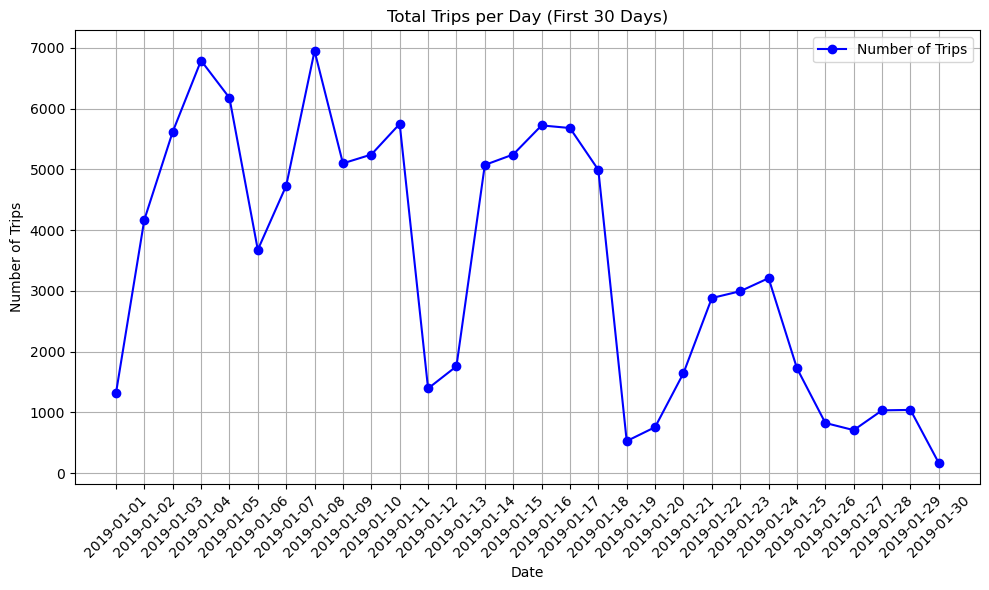

In [7]:
#Total Trips per Day (for a subset of data)
import matplotlib.pyplot as plt
subset_data = agg_data.head(30)
plt.figure(figsize=(10, 6))
plt.plot(subset_data['_id'], subset_data['count'], marker='o', color='b', label='Number of Trips')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.title('Total Trips per Day (First 30 Days)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

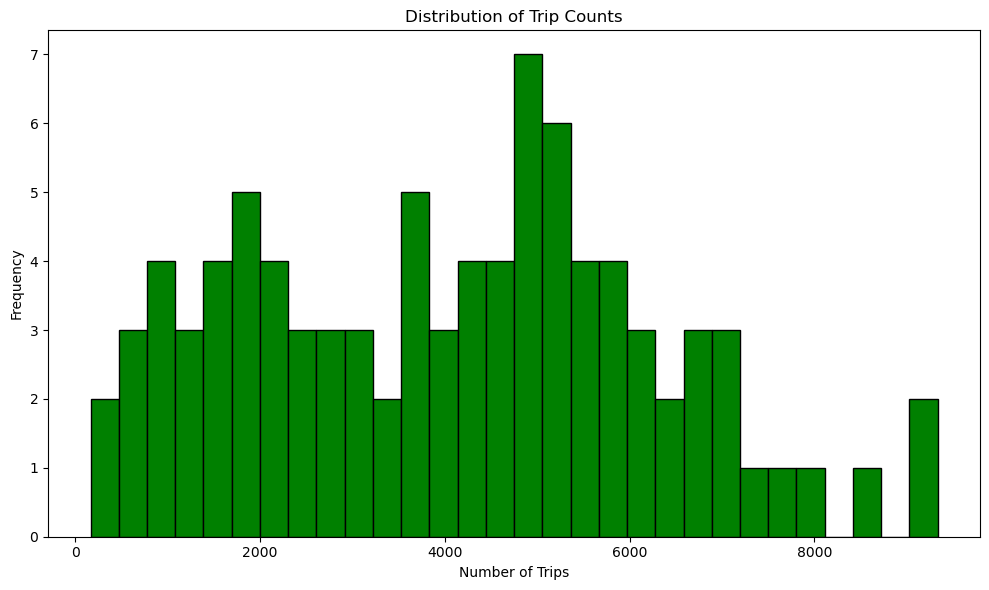

In [8]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(agg_data['count'], bins=30, color='green', edgecolor='black')
plt.title('Distribution of Trip Counts')
plt.xlabel('Number of Trips')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

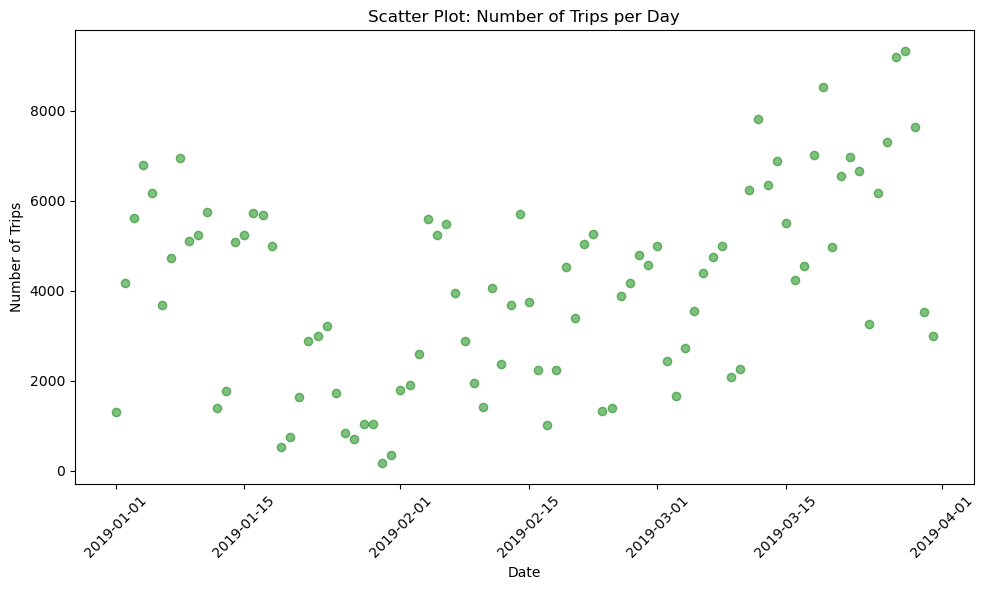

In [9]:
# Converting '_id' to a datetime object for better plotting
agg_data['_id'] = pd.to_datetime(agg_data['_id'])

# Scatter Plot Number of Trips Per Day
plt.figure(figsize=(10, 6))
plt.scatter(agg_data['_id'], agg_data['count'], color='green', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.title('Scatter Plot: Number of Trips per Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

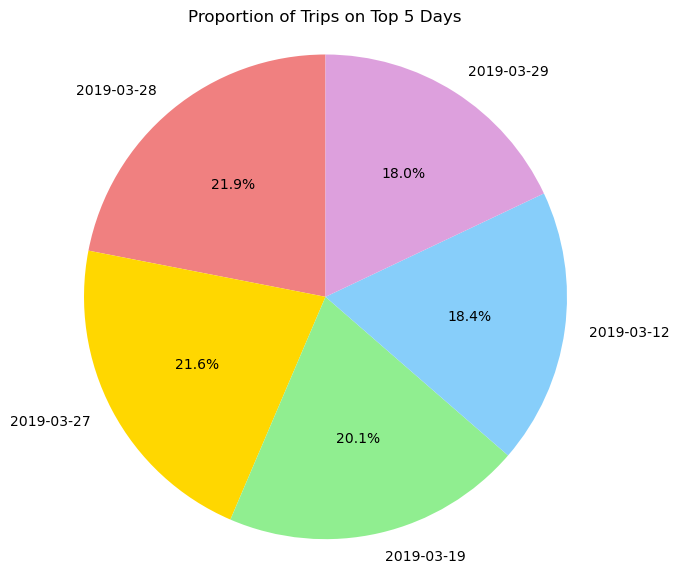

In [10]:
# Pie Chart Proportion of Trips Per Day (Top 5 Days)
top_days = agg_data.nlargest(5, 'count')
plt.figure(figsize=(7, 7))
plt.pie(top_days['count'], labels=top_days['_id'].dt.strftime('%Y-%m-%d'), autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'gold', 'lightgreen', 'lightskyblue', 'plum'])
plt.title('Proportion of Trips on Top 5 Days')
plt.axis('equal')  
plt.show()